In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hazing-images-dataset-cvpr-2019/GT/41_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/49_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/21_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/15_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/36_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/42_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/18_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/48_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/25_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/52_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/29_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/45_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/20_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/50_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/16_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/33_GT.png
/kaggle/input/hazing-images-dataset-cvpr-2019/GT/10_GT.p

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class HazyDataset(Dataset):
    def __init__(self, hazy_files, gt_files, transform=None):
        self.hazy_files = hazy_files
        self.gt_files = gt_files
        self.transform = transform

    def __len__(self):
        return len(self.hazy_files)

    def __getitem__(self, idx):
        hazy_img_path = self.hazy_files[idx]
        gt_img_path = self.gt_files[idx]

        hazy_image = Image.open(hazy_img_path).convert('RGB')
        gt_image = Image.open(gt_img_path).convert('RGB')

        if self.transform:
            hazy_image = self.transform(hazy_image)
            gt_image = self.transform(gt_image)

        return hazy_image, gt_image


In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class HazyDataset(Dataset):
    def __init__(self, hazy_files, gt_files, transform=None):
        self.hazy_files = hazy_files
        self.gt_files = gt_files
        self.transform = transform

    def __len__(self):
        return len(self.hazy_files)

    def __getitem__(self, idx):
        hazy_img_path = self.hazy_files[idx]
        gt_img_path = self.gt_files[idx]

        hazy_image = Image.open(hazy_img_path).convert('RGB')
        gt_image = Image.open(gt_img_path).convert('RGB')

        if self.transform:
            hazy_image = self.transform(hazy_image)
            gt_image = self.transform(gt_image)

        return hazy_image, gt_image
from torch.utils.data import DataLoader


import os

hazy_dir = "/kaggle/input/hazing-images-dataset-cvpr-2019/hazy"
hazy_files = sorted([os.path.join(hazy_dir, f) for f in os.listdir(hazy_dir)])


gt_dir = "/kaggle/input/hazing-images-dataset-cvpr-2019/GT"
gt_files = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir)])




# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset and dataloader
dataset = HazyDataset(hazy_files, gt_files, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# Initialize models
netG = Generator()
netD = Discriminator()

# Loss functions
criterion_GAN = nn.BCELoss()
criterion_content = nn.L1Loss()
# Verify the model parameters
print("Generator parameters:", list(netG.parameters()))
print("Discriminator parameters:", list(netD.parameters()))

# Optimizers
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Check if optimizers are correctly receiving parameters
print("OptimizerG parameters:", optimizerG.param_groups[0]['params'])
print("OptimizerD parameters:", optimizerD.param_groups[0]['params'])


Generator parameters: [Parameter containing:
tensor([[[[-7.7045e-02,  1.2659e-04,  1.6274e-02,  1.3642e-01],
          [-1.4371e-01,  7.5883e-02, -6.6082e-02, -9.2809e-02],
          [-1.0713e-01,  4.3947e-02, -9.3904e-02, -8.2711e-02],
          [-9.5963e-02, -8.9239e-02,  7.0405e-02,  9.4766e-02]],

         [[-2.9907e-02,  1.0813e-01,  1.1737e-01, -2.2736e-02],
          [-9.2907e-02, -3.2295e-02,  5.5576e-02, -8.6999e-02],
          [-1.8717e-04,  2.3865e-02,  6.7598e-03, -7.1854e-02],
          [-4.6053e-02,  3.8089e-02,  2.0631e-02, -1.1876e-02]],

         [[-4.8645e-02,  1.1878e-01, -3.8875e-02, -4.0357e-02],
          [ 3.2698e-02,  3.8374e-02, -6.2643e-02, -3.3615e-02],
          [-3.2893e-02, -1.2434e-01, -9.6166e-02, -8.6848e-02],
          [ 8.1996e-02, -8.3370e-02,  5.2407e-02, -1.1925e-01]]],


        [[[-1.0317e-01, -7.1292e-03,  4.0574e-02,  5.1200e-02],
          [-9.0580e-02, -3.3449e-02, -1.1282e-01,  1.2891e-01],
          [ 7.1920e-03, -5.9168e-02, -7.7050e-03, -

In [6]:
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make sure models are on the correct device
netG.to(device)
netD.to(device)

for epoch in range(num_epochs):
    for i, (hazy_image, gt_image) in enumerate(dataloader):
        hazy_image, gt_image = hazy_image.to(device), gt_image.to(device)

        # Train Discriminator
        optimizerD.zero_grad()
        output_real = netD(gt_image).view(-1)
        label_real = torch.full(output_real.size(), 1, dtype=torch.float, device=device)
        loss_D_real = criterion_GAN(output_real, label_real)

        fake_image = netG(hazy_image)
        output_fake = netD(fake_image.detach()).view(-1)
        label_fake = torch.full(output_fake.size(), 0, dtype=torch.float, device=device)
        loss_D_fake = criterion_GAN(output_fake, label_fake)

        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        optimizerD.step()

        # Train Generator
        optimizerG.zero_grad()
        output_fake = netD(fake_image).view(-1)
        loss_G_GAN = criterion_GAN(output_fake, label_real)  # Use real labels for fake images for generator loss
        loss_G_content = criterion_content(fake_image, gt_image)
        loss_G = loss_G_GAN + loss_G_content * 100
        loss_G.backward()
        optimizerG.step()

        if i % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], '
                  f'Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}')

print("Training complete")


Epoch [0/100], Step [0/4], Loss D: 0.8215, Loss G: 45.8442
Epoch [1/100], Step [0/4], Loss D: 0.6356, Loss G: 39.2815
Epoch [2/100], Step [0/4], Loss D: 0.4898, Loss G: 40.4447
Epoch [3/100], Step [0/4], Loss D: 0.4101, Loss G: 36.0762
Epoch [4/100], Step [0/4], Loss D: 0.4249, Loss G: 40.1707
Epoch [5/100], Step [0/4], Loss D: 0.3065, Loss G: 40.2501
Epoch [6/100], Step [0/4], Loss D: 0.4689, Loss G: 38.5126
Epoch [7/100], Step [0/4], Loss D: 0.3353, Loss G: 38.0030
Epoch [8/100], Step [0/4], Loss D: 0.2258, Loss G: 36.0747
Epoch [9/100], Step [0/4], Loss D: 0.1948, Loss G: 37.2935
Epoch [10/100], Step [0/4], Loss D: 0.3208, Loss G: 36.9926
Epoch [11/100], Step [0/4], Loss D: 0.5056, Loss G: 37.8870
Epoch [12/100], Step [0/4], Loss D: 0.2116, Loss G: 39.4545
Epoch [13/100], Step [0/4], Loss D: 0.3677, Loss G: 38.5653
Epoch [14/100], Step [0/4], Loss D: 0.2308, Loss G: 31.4152
Epoch [15/100], Step [0/4], Loss D: 0.1980, Loss G: 36.3821
Epoch [16/100], Step [0/4], Loss D: 0.2363, Loss G

In [7]:
import torch

# Assuming model is your PyTorch model
torch.save(netG.state_dict(), 'netG.pth')
torch.save(netD.state_dict(), 'netD.pth')


In [8]:
# Load the state dictionaries
netG.load_state_dict(torch.load('/kaggle/working/netG.pth'))
netD.load_state_dict(torch.load('/kaggle/working/netD.pth'))

<All keys matched successfully>

In [9]:
netG.eval()
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

Average PSNR: 13.847867095584562
Average SSIM: 0.20897570238872007


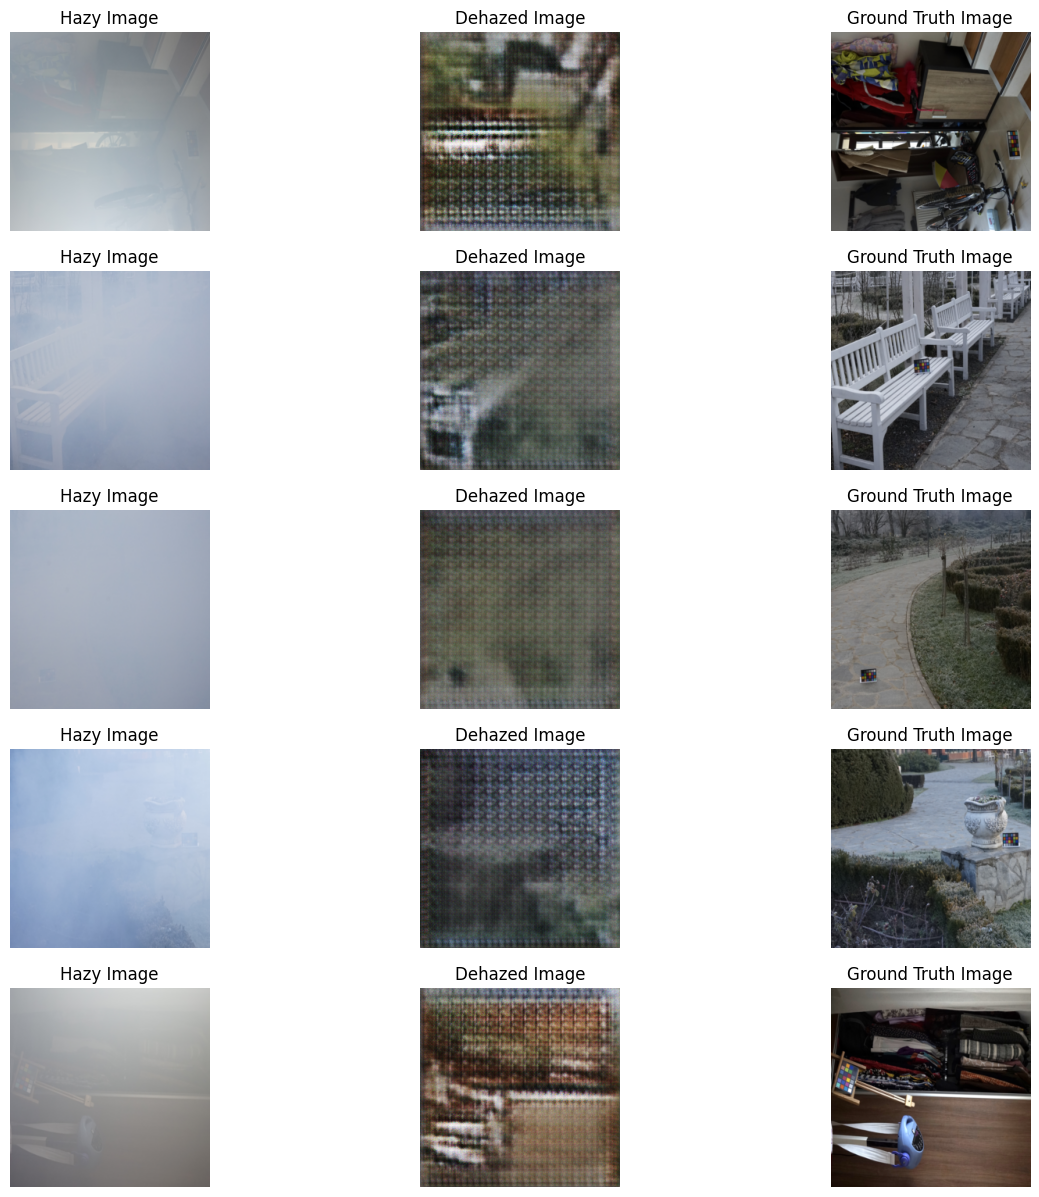

In [11]:
# Assuming netG is on the GPU, typically you have done something like:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# netG.to(device)

# Process all images in the dataloader
for hazy_images, gt_images in dataloader:
    # Move hazy_images and gt_images to the same device as netG
    hazy_images = hazy_images.to(device)  # Move hazy images to the same device
    gt_images = gt_images.to(device)      # Move ground truth images to the same device

    with torch.no_grad():
        dehazed_images = netG(hazy_images)

    # Convert tensors to images and store them
    for i in range(hazy_images.size(0)):
        hazy_image = tensor_to_image(hazy_images[i])
        dehazed_image = tensor_to_image(dehazed_images[i])
        gt_image = tensor_to_image(gt_images[i])

        hazy_images_list.append(hazy_image)
        dehazed_images_list.append(dehazed_image)
        gt_images_list.append(gt_image)

        # Calculate PSNR and SSIM
        psnr_value = psnr(gt_image, dehazed_image, data_range=dehazed_image.max() - dehazed_image.min())
        ssim_value = ssim(gt_image, dehazed_image, win_size=11, data_range=dehazed_image.max() - dehazed_image.min(), channel_axis=-1)

        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

# Print average PSNR and SSIM
avg_psnr = sum(psnr_values) / len(psnr_values)
avg_ssim = sum(ssim_values) / len(ssim_values)

print(f'Average PSNR: {avg_psnr}')
print(f'Average SSIM: {avg_ssim}')

# Display a few images (optional)
fig, axs = plt.subplots(5, 3, figsize=(15, 15))
for i in range(5):
    axs[i, 0].imshow(hazy_images_list[i])
    axs[i, 0].set_title('Hazy Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(dehazed_images_list[i])
    axs[i, 1].set_title('Dehazed Image')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(gt_images_list[i])
    axs[i, 2].set_title('Ground Truth Image')
    axs[i, 2].axis('off')

plt.show()


In [12]:
import pandas as pd
Error=pd.DataFrame({'psnr_values':psnr_values,'ssim_values':ssim_values})

In [ ]:
Error

In [ ]:
Error.describe()

In [13]:
Error.to_csv('/kaggle/working/evaluation_results.csv', index=False)